In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as sp
import scipy.optimize as spo
import findiff as fd

In [2]:
lj_sigma = 1.46
lj_eps = 0.405

In [3]:
def f_lj(r):
    a = lj_sigma / r
    return 4 * lj_eps * (np.pow(a, 12) - np.pow(a, 6))

In [4]:
def scatter(X, Y, cond):
    X = X[cond]
    Y = Y[cond]
    plt.scatter(X, Y)
    for i, txt in enumerate(zip(X,Y)):
        txt = f"{txt[0]:.3f}, {txt[1]:.3f}"
        plt.annotate(txt, (X[i], Y[i]))

In [5]:
def scatter_one(x, y):
    plt.scatter(x, y)
    txt = f"{x:.3f}, {y:.3f}"
    plt.annotate(txt, (x, y))

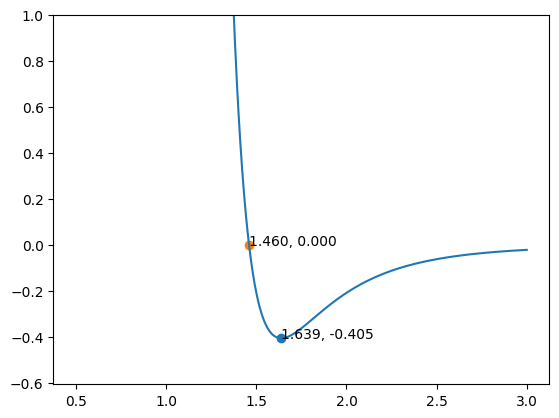

In [6]:
R = np.linspace(0.5, 3, 2000)
E = f_lj(R)

plt.plot(R, E)
plt.ylim((E.min() -0.2, 1))

scatter(R, E, E == E.min())
scatter_one(lj_sigma, f_lj(lj_sigma))

In [7]:
zbl_Z1 = 6
zbl_Z2 = 6
zbl_eps0 = 55.26349406 * 1e-4
zbl_eps0

0.005526349406

In [8]:
def f_phi(x):
    c1 = 0.02817
    c2 = 0.28022
    c3 = 0.50986
    c4 = 0.18175
    d1 = 0.20162
    d2 = 0.40290
    d3 = 0.94229
    d4 = 3.19980
    e1 = np.exp(-d1*x)
    e2 = np.exp(-d2*x)
    e3 = np.exp(-d3*x)
    e4 = np.exp(-d4*x)
    return c1*e1 + c2*e2 + c3*e3 * c4*e4

def f_zbl(r):
    a = 0.4685 / (np.pow(zbl_Z1, 0.23) + np.pow(zbl_Z2, 0.23))
    phi = f_phi(r / a)
    E = 1.6 * 9 * zbl_Z1 * zbl_Z2 / r
    E *= phi
    return E

(-0.8813533110640721, 100.0)

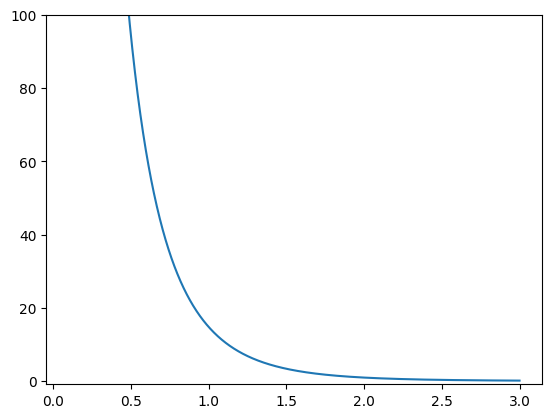

In [9]:
R = np.linspace(0.1, 3, 2000)
E = f_zbl(R)

plt.plot(R, E)
plt.ylim((E.min() - 1, 100))

(1.0, 1.5)

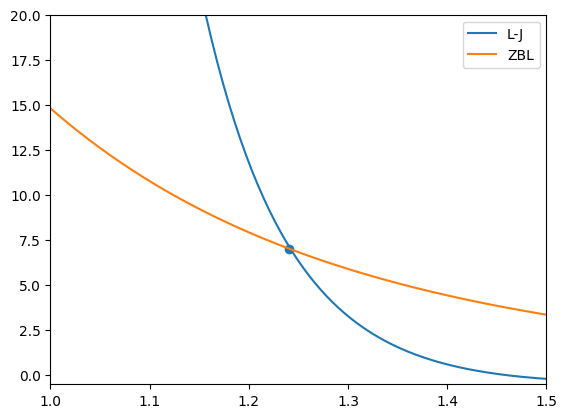

In [10]:
R = np.linspace(0.1, 3, 1000)
E_zbl = f_zbl(R)
E_lj = f_lj(R)
idx = np.argwhere(np.diff(np.sign(E_zbl - E_lj))).flatten()[0]

plt.plot(R, E_lj)
plt.plot(R, E_zbl)
plt.scatter(R[idx], E_zbl[idx])
plt.legend(["L-J", "ZBL"])
plt.ylim((E_lj.min() -0.1, 20))
plt.xlim((1, 1.5))

(-1.0, 100.0)

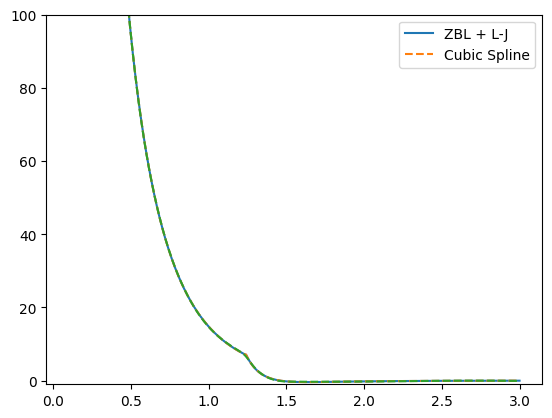

In [11]:
center = R[idx]
delta_l = 0.0
delta_r = 0.0
left_i = np.abs(R - (center - delta_l)).argmin()
right_i = np.abs(R - (center + delta_r)).argmin()

R_1 = R[:left_i]
R_2 = R[right_i:]
R_mid = R[left_i:right_i]
R_new = np.append(np.append(R_1, R_mid), R_2)

E_ljzbl = f_zbl(R_1)
E_ljzbl = np.append(E_ljzbl, f_lj(R_2))
#E_exp = 
spl = sp.CubicSpline(R_new, E_ljzbl)
sspl = sp.BSpline(*sp.splrep(R_new, E_ljzbl, s=10))
#exp_coeffs = spo.curve_fit(lambda a,t,b_0,b_1,b_2,b_3,b_4,b_5: np.exp(b_0 + b_1*t + b_2*np.pow(t, 2) + b_3*np.pow(t, 3) + b_4*np.pow(t, 4) + b_5*np.pow(t, 5)) + a,  R_mid,  y,  p0=(4, 0.1))

new_E = spl(R_new)
snew_E = sspl(R_new)

plt.plot(R_new, E_ljzbl)
plt.plot(R_new, new_E, '--')
plt.plot(R_new, snew_E, '--')
plt.legend(["ZBL + L-J", "Cubic Spline"])
plt.ylim((-1, 100))
#plt.xlim((1, 1.5))

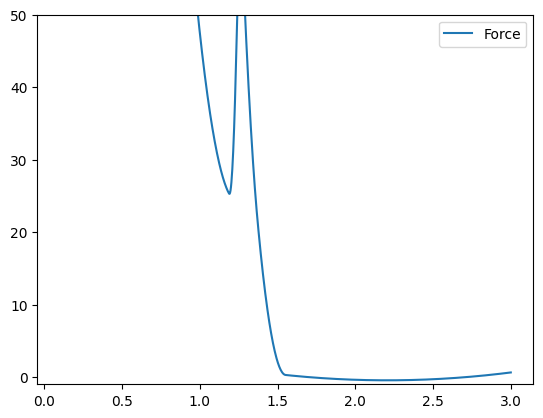

In [12]:
#R = np.linspace(0.1, 3, 3000)
N = np.linspace(1, R.shape[0], R.shape[0])
E_sp = sspl(R)
d_x = R[2] - R[1]
dev = fd.FinDiff(0, d_x)
F_sp = -1 * dev(E_sp)

plt.plot(R, F_sp)
plt.legend(["Force"])
#plt.xlim((1, 1.5))
plt.ylim((-1,50))
np.savetxt("E_ljzbl.txt", np.c_[N, R, E_sp, F_sp])

[  -1.3591717    12.99350575  -45.86304994  107.95180773 -138.61243825
   88.64860324  -22.32826016]


(-1.0, 100.0)

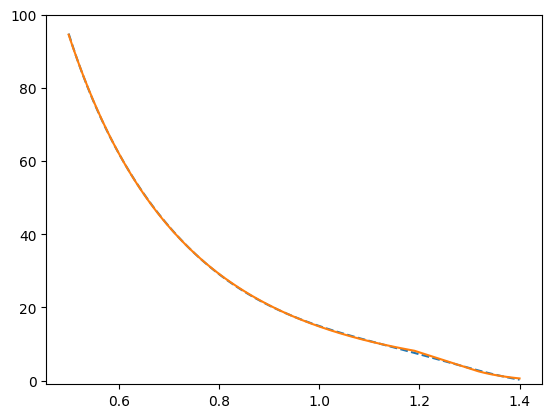

In [13]:
R_x = np.linspace(0.5, 1.4, 1000)
center = R[idx]
delta_l = 0.05
delta_r = 0.05
left_i = np.abs(R_x - (center - delta_l)).argmin()
right_i = np.abs(R_x - (center + delta_r)).argmin()

R_1 = R_x[:left_i]
R_2 = R_x[right_i:]
R_new = np.append(R_1, R_2)

def f_exp(t, a, b_0, b_1, b_2, b_3, b_4, b_5):
    return np.exp(b_0 + b_1 *t + b_2 *np.pow(t, 2) + b_3 *np.pow(t, 3) + b_4 *np.pow(t, 4) + b_5 *np.pow(t, 5)) + a

E_exp = np.append(f_zbl(R_1), f_lj(R_2))
exp_coeffs = spo.curve_fit(f_exp,  R_new,  E_exp, p0 = (1.89471576, 8.73103054, -20.4199227, 54.38169682, -95.0912425, 82.63594776, -27.62149251))[0]
print(exp_coeffs)
new_expE = f_exp(R_new, *exp_coeffs)
plt.plot(R_new, new_expE, '--')
plt.plot(R_new, E_exp)
plt.ylim((-1, 100))

(-1.0, 50.0)

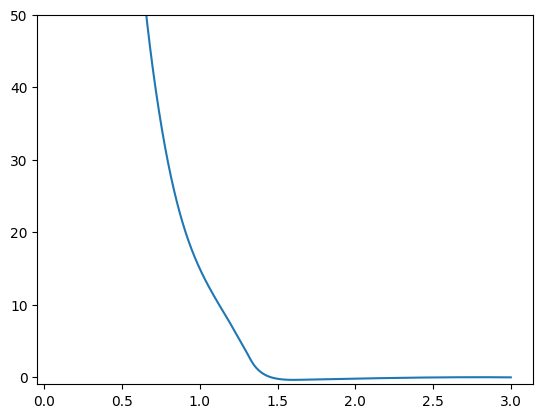

In [14]:
R_1 = np.linspace(0.1, 0.49, 500)
R_2 = np.linspace(1.41, 3, 2000)
E_exp_fin = np.append(np.append(f_zbl(R_1), new_expE), f_lj(R_2))
R_fin = np.append(np.append(R_1, R_new), R_2)
spl = sp.BSpline(*sp.splrep(R_fin, E_exp_fin, s=15))
new_E_fin = spl(R_fin)
plt.plot(R_fin, new_E_fin)
plt.ylim((-1, 50))

(-1.0, 1000.0)

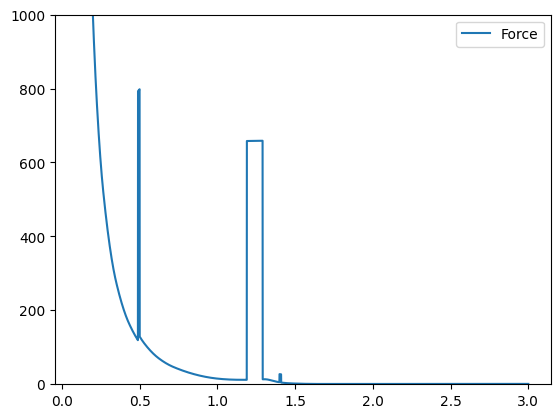

In [15]:
N = np.linspace(1, R_fin.shape[0], R_fin.shape[0])
d_x = R[2] - R[1]
dev = fd.FinDiff(0, d_x)
F_sp = -1 * dev(new_E_fin)

plt.plot(R_fin, F_sp)
plt.legend(["Force"])
#plt.xlim((1, 1.5))
plt.ylim((-1,1000))
#np.savetxt("E_ljzbl.txt", np.c_[N, R_fin, new_E_fin, F_sp])

ValueError: x and y must have same first dimension, but have shapes (1000,) and (61,)

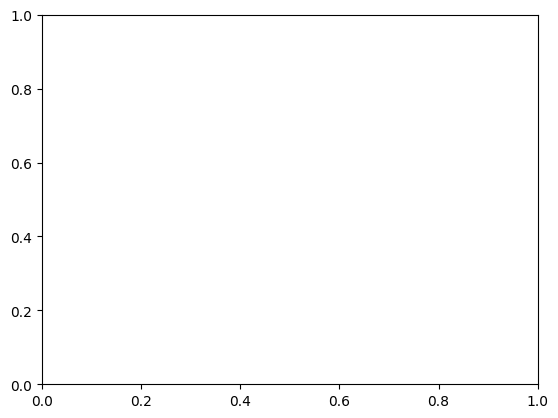

In [16]:
inp = np.loadtxt("lj.txt")
#R = inp[:, 0]
E = inp[:, 1]

E_lj = f_lj(R)

plt.plot(R, E, ".", markersize=10)
plt.plot(R, E_lj)
plt.legend(["experiment", "math"])
plt.ylim(-1, 100)

In [ ]:
inp = np.loadtxt("zbl.txt")
#R = inp[:, 0]
E = inp[:, 1]

E_zbl = f_zbl(R)

plt.plot(R, E, ".", markersize=10)
plt.plot(R, E_zbl)
plt.legend(["experiment", "math"])
plt.ylim(-1, 100)

In [ ]:
file = "LJ_ZBL_CC"
with open(file) as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    if i > 5:
        tokens = line.split()
        tokens = [float(token) for token in tokens]
        line = f"{int(tokens[0])} {tokens[1]:.6f} {tokens[2]:.6f} {tokens[3]:.6f}\n"
    lines[i] = line

with open(file, mode="w") as f:
    for line in lines:
        f.write(line)

In [ ]:
inp = np.loadtxt("lj_zbl.txt")
#R = inp[:, 0]
E = inp[:, 1]
E_sp = spl(R)

plt.plot(R, E, ".", markersize=10)
plt.plot(R, E_sp)
plt.legend(["experiment", "math"])
plt.ylim(-1, 100)